# Сколько больничных коек нужно для вопроизводства населения в городах РФ - аналитическое исследование данных Росстата

## Введение

Вниманию читателя предлагается решение задачи бинарной классификации на основе линейной регрессии показателя прироста населения крупных городов России в координатах (уровень здоровья, уровень медицинского обеспечения).  Линии уровня вероятностной функции интерпретируются как обеспеченность (от 0 до 100%) больничными койко-местами в зависимости от неблагополучности ситуации со здоровьем населения в каждом месте.  Результаты могут быть использованы для принятия решения о расширении системы стационаров в конкретном населенном пункте.  В исследовании используются открытые данные Росстата.

## Источник данных

Воспользуемся открытым датасетом Росстата по социальным показателям крупных городов России.  Его можно скачать на сайте АНО «ЦПУР» вместе с pdf-описанием семантики полей:

Крупные города России: объединенные данные по основным социально-экономическим показателям за 1985-2019 гг. // Росстат; обработка: Гостева И., Казанцев К. Инфраструктура научно-исследовательских данных, АНО «ЦПУР», 2021. Доступ: Лицензия CC BY-SA. Размещено: 09.12.2021. (Ссылка на набор данных: http://data-in.ru/data-catalog/datasets/187/)

## Чтение и предобработка данных

In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
import math as math
from scipy.optimize import fsolve

import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
raw_df = pd.read_csv('datasets/data.csv', sep=';')

print('\nНазвания полей исходного датасета Росстата: \n', raw_df.columns)


Названия полей исходного датасета Росстата: 
 Index(['region', 'municipality', 'settlement', 'oktmo', 'latitude_dd',
       'longitude_dd', 'year', 'assets', 'assets_depreciation',
       'assets_exhausted', 'assets_new', 'birth', 'build_flat', 'catering',
       'catering_growth', 'collective_foreign', 'collective_people',
       'collective_russian', 'comp_electr', 'comp_manufact', 'comp_mining',
       'construction', 'crimes', 'criminals', 'death', 'doctors',
       'doctors_per10', 'domesticserv', 'hospital_beds', 'hospital_beds_per10',
       'hospitals', 'industry', 'invest_budg', 'invest_fed', 'invest_reg',
       'investment', 'job_regist', 'job_regist_unempl', 'job_seeker',
       'job_seeker_unempl', 'living_space', 'migration', 'n_companies',
       'new_hospital_beds', 'new_housing', 'new_polycl_visits',
       'new_preschool_places', 'new_school_places', 'nurses', 'nurses_per10',
       'pens', 'pension', 'polycl_visits', 'polycl_visits_per10', 'polyclinic',
       'pop_

Как мы видим, в данных огромное количество полей (77) - примерно по 10 социальным темам (демография, безработица, доход населения, медицина, образование, культура, строительство жилья и соц-объектов, сфера услуг, преступность и т.д. ), в каждой в среднем по 7-8 удельных и абсолютных параметров.  Поэтому предварительный обзор полей по темам лучше делать инструментами BI, например, на данном дашборде в Tableau.Public автор провел быстрое предварительное ознакомление с интересными зависимости индекса прироста населения:  https://public.tableau.com/views/GovTrial-MainCitiesSocialFigures/Dashboard2?:language=en-US&:display_count=n&:origin=viz_share_link .

После предварительного визуального обзора полей в Tableau нас заинтересовала зависимость Индекса естественного прироста/убыли на 1000 человек населения города от обеспеченности больничными койкоместами в зависимости от уровня здоровья населения (левый нижний график на дашборде Tableau.Public по ссылке выше, ниже мы его посторим средствами библиотеки seaborn).  Для краткости изложения ниже сократим и наш датасет до нужных полей и анонимизируем данные, убрав названия городов.  Также удалим статистику СССР и 90-х:

In [3]:
df = raw_df[['oktmo','rni','polycl_visits_per10','hospital_beds_per10','population','year']].dropna(
           ).query('2000 <= year').reset_index(drop=True)

print('\nВсего присутствуют данные за', df['year'].nunique(), 'лет:')
print('      по', df['oktmo'].nunique(), 'крупному городу РФ.', '\n','-'*50)
df.info()


Всего присутствуют данные за 20 лет:
      по 201 крупному городу РФ. 
 --------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3445 entries, 0 to 3444
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   oktmo                3445 non-null   int64  
 1   rni                  3445 non-null   float64
 2   polycl_visits_per10  3445 non-null   float64
 3   hospital_beds_per10  3445 non-null   float64
 4   population           3445 non-null   float64
 5   year                 3445 non-null   int64  
dtypes: float64(4), int64(2)
memory usage: 161.6 KB


Посмотрим визуально, как позиционируются значения индексов прироста населения городов в удельных координатах (X = *число больничных коек*, Y = *частота обращения ко врачам за смену*) - в пересчете на 10 000 населения.  Так как визуально трудно воспринимать палитру с широким спектром цветов, для визуализации введем 5 уровней значения индекса прироста, соответственно ожидая 5 цветов в легенде:

In [4]:
def level_f(x):
    if abs(x) <= 2: return 0  # это значение будет означать что прирост близок к нулю
    elif x > 10:    return 2  # это значение будет означать большой прирост (более 1% в год)
    elif x > 0:     return 1  # это значение будет означать умеренный прирост (в пределах 1% в год)
    elif x > -5:    return -1 # это значение будет означать умеренную убыль (в приделах 0.5% в год)
    else:           return -2 # это значение будет означать большую убыль (более 0.5% в год)

df['RNI_level'] = df['rni'].map(level_f)

Теперь можно проводить визуализацию:


ЗАВИСИМОСТЬ ДИНАМИКИ РОСТА НАСЕЛЕНИЯ ОТ УРОВНЕЙ ЗДОРОВЬЯ НАСЕЛЕНИЯ И ОБЕСПЕЧЕННОСТИ БОЛЬНИЧНЫМИ КОЙКАМИ:


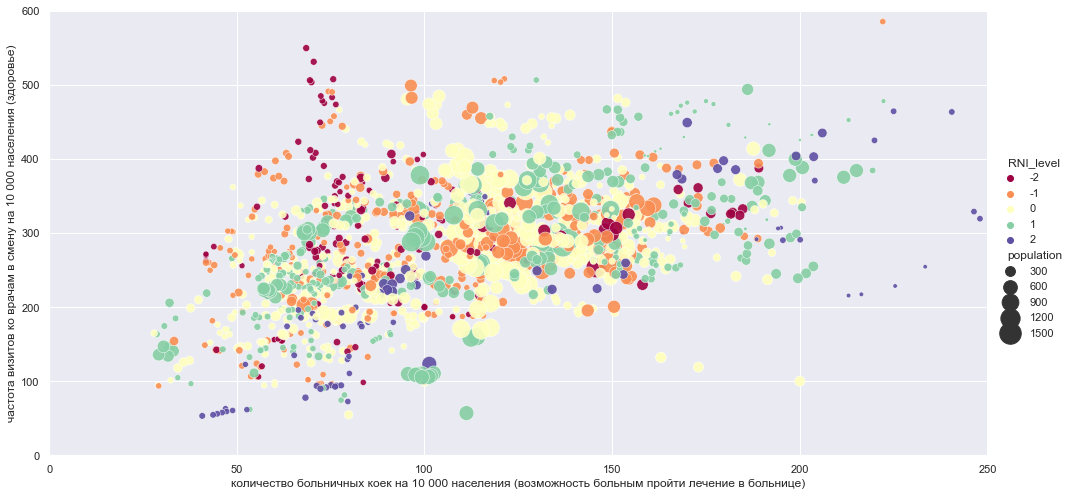

In [5]:
print('\nЗависимость динамики роста населения от уровней здоровья населения и обеспеченности больничными койками:'.upper())
sns.set_theme()
cmap = sns.color_palette("Spectral", as_cmap=True)

sns.relplot(
    data=df.query('year >= 2010 & (10 < polycl_visits_per10 < 600)'),
    x="hospital_beds_per10", y="polycl_visits_per10",
    hue="RNI_level", size="population",
    height=7, aspect=2,
    palette=cmap, sizes=(10, 500),
    alpha = 0.9
)

def show_our_graph():   # далее мы все время будем использовать одни и те же координаты - вынесем код в функцию
    plt.xlim(0,250)
    plt.ylim(0,600)
    plt.xlabel('количество больничных коек на 10 000 населения (возможность больным пройти лечение в больнице)')
    plt.ylabel('частота визитов ко врачам в смену на 10 000 населения (здоровье)')
    plt.show()
show_our_graph()

**Пояснения** к графику выше:
* размер точки показывает размер города по населению - согласно легенде справа,
* цвет точки означает уровень прироста населения в городе: от синего (максимальный) до красного (минимальный - максимальная убыль населения) - согласно легенде справа
* период данных - десять лет с 2010 включительно

## План дальнейших действий

Несмотря на сильную замешенность данных с разным уровнем индекса роста населения в выбранных координатах, можно заметить, что все они лежат в некотором раструбе углов, причем возле максимального (с осью Х) угла находятся преимущественно неблагоприятные города, а возле минимального угла - самые благоприятные города.  Большинство же нулевых значений группируются ближе к биссектрисе данного раструба углов.

Этому можно дать такое естественное объяснение, что удельная частота визитов ко врачам свидетельствует о проблемах со здоровьем у населения, соответственно чем она больше - тем больше больничных коек требуется для поправки здоровья населению.  Если больничных коек не хватает, то это приволит к убыли населения.

Разумеется, факторов гораздо больше - сказывается и возрастной состав населения, и рождаемость с ее факторами, и региональные традиции в плане обращения ко врачам.  Именно поэтому замес данных такой большой.  Но в среднем можно ожидать описанного поведения.  Тогда мы можем описывать ситуацию в терминах уровня достаточности больничных коек текущей ситуации со здоровьем населения.

Первая же идея, которая возникает из рассуждения выше: давайте проведем бинарную классификацию, которая поделит города на два класса: растущие или теряющие население - и соответствующая граница этих классов в наших координатах будет искомой функцией (не)достаточности больничных коек.

После чуть более долгого вглядывания в данные можно прийти к выводу, что они позволяют получить немного больше, чем просто бинарную классификацию - ведь значения индекса прироста населения являются неплохой целевой переменной, из регрессии которой можно получить хорошую функцию уверенности классификации: $ <w,x_i> $ , а линии уровня ее сигмоиды дадут нам что-то вроде искомого "уровня обеспеченности койками" (можно даже нормировать на 100%).

Конечно, произвольность выбора и функции уверенности классификации, и сигмоиды (а не арктангенса, например) ставят под вопрос физический смысл получаемых процентов обеспеченности койками.  Но пока в задаче нет строгого определения, что значит процент обеспеченности койками, годится и так - функция в любом случае будет монотонной по значению регрессионной уверенности.

Общий план выглядит логично - приступаем к реализации.

## Подготовка выборки для регрессии

Заметим, что наши данные не равнозначны - города находятся в большом диапазоне численности населения (в тысячах человек): 

In [6]:
df.query('year >= 2010 & (10 < polycl_visits_per10 < 600)')['population'].describe(
                                                          ).drop(index=['25%','50%','75%','std']).astype('int')

count    1690
mean      334
min        13
max      1625
Name: population, dtype: int32

Поэтому, строго говоря, надо учитывать каждую точку с ее весом, пропорциональным численности.  Но мы поступим проще - будем считать, что объектами являются группы по 10 000 человек с теми же удельными характеристиками, что и у города, откуда соответствующие данные (в каждом году).  Тогда в выборке город из 100 000 человек болжен быть представлен 10 объектами с одинаковыми (X,Y).  По мере изменения населения со временем, в иной год, он может быть представлен другим количеством объектов.

Сгенерим такую выборку:

In [7]:
hb = []  # здесь будет параметр hospital_beds_per10
pv = []  # здесь будет параметр polycl_visits_per10
rni = []  # здесь будет параметр rni

good_df = df.query('year >= 2010 & (10 < polycl_visits_per10 < 600)')

for i in range(len(good_df)):
    oktmo, z, y, x, population, year, RNI_level = good_df.iloc[i] 
    for j in range(int(population)//10):
        hb.append(x)
        pv.append(y)
        rni.append(z)

print('Длина полученной выборки', len(rni), 'равнозначных объектов по 10 000 человек.')

Длина полученной выборки 55703 равнозначных объектов по 10 000 человек.


In [8]:
Y = np.array(rni)
Xhb = np.array(hb)
Xpv = np.array(pv)
X = np.array([Xhb, Xpv]).T

## Тренировка модели и визуализация результатов

Тренируем модель и записываем в датасет для визуализации результатов, добавляя сигмоиду предсказанной части прироста населения как скоринг уровня обеспеченности больничными койками.  Затем смотрим значения скоринга в тех же координатах.

In [9]:
MLR_model = linear_model.LinearRegression()
MLR_model.fit(X,Y)

show_df = pd.DataFrame(X).rename(columns={0:'hb',1:'pv'})
show_df['rni'] = Y
show_df['rni_pred'] = MLR_model.predict(X)
show_df['score'] = show_df['rni_pred'].map(lambda x: (1 / (1 + math.exp(-x)))*100 )


УСРЕДНЕННЫЙ ПО ВСЕЙ РОССИИ СКОРИНГ ОБЕСПЕЧЕННОСТИ БОЛЬНИЧНЫМИ КОЙКАМИ ПРИ РАЗЛИЧНОМ УРОВНЕ ЗДОРОВЬЯ НАСЕЛЕНИЯ:


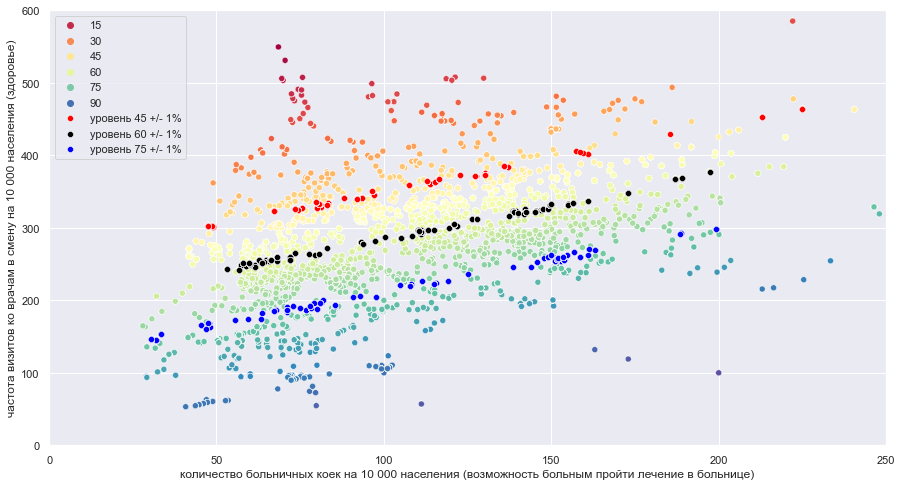

In [10]:
print(
'\nУсредненный по всей России скоринг обеспеченности больничными койками при различном уровне здоровья населения:'.upper())

plt.figure(figsize=(15,8))
sns.set_theme()
cmap = sns.color_palette("Spectral", as_cmap=True)

sns.scatterplot( data=show_df, x="hb", y="pv", hue="score", palette=cmap)

sns.scatterplot( data=show_df.query('-1 < score - 45 < 1'), 
                x="hb", y="pv", color='red', markers='v', label='уровень 45 +/- 1%')
sns.scatterplot( data=show_df.query('-1 < score - 60 < 1'), 
                x="hb", y="pv", color='black', markers='x', label='уровень 60 +/- 1%')
sns.scatterplot( data=show_df.query('-1 < score - 75 < 1'), 
                x="hb", y="pv", color='blue', markers='^', label='уровень 75 +/- 1%')

show_our_graph()

### Линии уровня функции скоринга

Характер линий уровня функции скоринга хорошо виден для центра оаспределения 60 +/- 15% на рисунке сверху, однако для значений скоринга вне этого диапазона объектов уже не достаточно, чтобы хорошо видеть прямые, поэтому также отрисуем уже сами дилии для всего диапазона значений скоринга в тех же координатах.

Нетренированная модель позволяет нам посчитать значение скоринга в любой точке графика:

In [11]:
def score_f(hb,pv):
    x = np.array(
        [
            [hb],[pv]
        ], dtype=object  # без указания типа будет выдавать много предопреждений при выполнении кода 
    ).T
    
    wx = MLR_model.predict(x)
    return (1 / (1 + math.exp(-wx)))*100

score_f(120,303.42)

59.99974206666327

Однако, для линии уровня нам придется использовать солвер, который по координате X и значению уровня будет возвращать нам значение координаты Y на данной линии уровня:

In [12]:
def pv_for_score_f(hb, score=60):
    
    def root_f(pv):
        return score_f(hb,pv) - score
    
    return fsolve(root_f,300)[0]

pv_for_score_f(120,60)

303.41885429503833

Обе функции исправно и согласованно работают:
* значение скоринга для 120 коек и 303.42 визитов в смену равно 60,
* солвер для 120 коек и уровня 60 вернул нам 303.42 визита в смену,
* эти результаты соответствуют графику выше и взаимосогласованы.

Можно строить график линий уровня скоринга:


ЛИНИИ УРОВНЯ СКОРИНГА ОБЕСПЕЧЕННОСТИ БОЛЬНИЧНЫМИ КОЙКАМИ ПРИ РАЗЛИЧНОМ УРОВНЕ ЗДОРОВЬЯ НАСЕЛЕНИЯ:


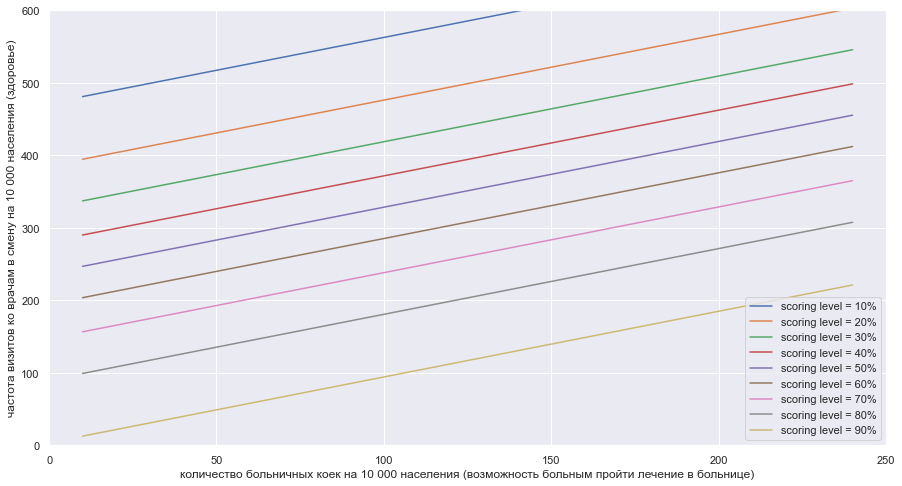

In [13]:
print(
'\nЛинии уровня скоринга обеспеченности больничными койками при различном уровне здоровья населения:'.upper())

plt.figure(figsize=(15,8))
sns.set_theme()

X = [10*i for i in range(1,25)]

for level in [10*i for i in range(1,10)]:
    plt.plot(X, [pv_for_score_f(hb, score=level) for hb in X], label='scoring level = '+str(level)+'%')

plt.legend()
show_our_graph()

## Заключительные выводы (по предпоследнему графику):
1. Уровень здоровья, при котором количество обращений ко врачам за одну смену составляет 1% от населения, является естественным здоровьем, не требующим госпитализаций, а обращения носят скорее формальный характер - справки, больничные, анализы.
2. Выше этого естественного уровня для каждых 10 000 населения на каждые 100 новых обращений ко врачам за смену требуется обеспеченность 100 коек стационара.
3. Это усредненные данные по городам России - стохастичность их огромна, но поскольку стохастичность лишь приводит к дополнительному горизонтированию регрессионной прямой ниже ее истинного наклона, мы можем рассматривать данную оценку как оценку с запасом - то есть этих 100 коек стационара на рост в 100 визитов за смену точно хватит, чтобы исправить ситуацию с убылью населения.